# PART1 1 input and 2 outputs without share-layer for multi-task learning

## The multi-output deep learning dataset
![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2018/05/keras_multi_output_dataset.jpg)


### In total, our dataset consists of 2,525 images across seven color + category combinations, including:

Black jeans (344 images)
Black shoes (358 images)
Blue dress (386 images)
Blue jeans (356 images)
Blue shirt (369 images)
Red dress (380 images)
Red shirt (332 images)

## 1. import the libraries and the variables

install the necessary libaries, the commands are showed as follows:
1. pip install matplotlib
2. pip install keras
3. pip install -U scikit-learn
4. pip install numpy
5. pip install argparse  <font color = red> (I installed in my Laptop) </font>
6. pip install opencv-python <font color = red> (I installed in my Laptop) </font>
7. pip install Pillow <font color = red> (I installed in my Laptop) </font>
6. pip install pandas <font color = red> (I installed in my Laptop) </font>

or you can select the environment in Anaconda, and select the necessary library to install

if you want to see the framework of model constrcting you have to install the libraries,
1. sudo apt-get insall graphviz or conda install graphviz
2. pip install pydot==1.2.3
3. pip install pydot-ng 

if it appears "AttributeError: module 'os' has no attribute 'errno'", 
please reference:
https://stackoverflow.com/questions/51852502/error-message-when-using-pydot-to-save-image-attributeerror-module-os-has-no

In [1]:
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import os
import cv2
from keras.utils import plot_model

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

Using TensorFlow backend.


## 2 load data

data.pkl contains five parts,
1. data:           original image data
2. categoryLB:     category name
3. colorLB:        color name
4. categoryLabels: category numeric labels
5. colorLabels:    color numeric labels

In [6]:
with open('data.pkl', 'rb') as file:
    all_data = pickle.load(file)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
data           = all_data['data']           # original image data
categoryLB     = all_data['categoryLB']     # category name
colorLB        = all_data['colorLB']        # color name
categoryLabels = all_data['categoryLabels'] # category numeric labels
colorLabels    = all_data['colorLabels']    # color numeric labels

In [9]:
print(data.shape)

print(categoryLB.classes_)
print(colorLB.classes_)
print(categoryLabels.shape)
print(colorLabels.shape)

(2521, 96, 96, 3)
['dress' 'jeans' 'shirt' 'shoes']
['black' 'blue' 'red']
(2521, 4)
(2521, 3)


## 3 data processing

In [10]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,
    test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,
    trainColorY, testColorY) = split

## 4 model construction



The model contains two special components, including:

   - <b>A branch early in the network that splits the network into two “sub-networks”</b>  — one responsible for clothing type classification and the other for color classification.
   - <b>A Two (disjoint) fully-connected heads at the end of the network</b>, each in charge of its respective classification duty.


![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2018/05/keras_multi_output_fashionnet_top.png)

![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2018/05/keras_multi_output_fashionnet_bottom.png)


We then immediately create two branches:

    The branch on the left is responsible for classifying the clothing category.
    The branch on the right handles classifying the color.

Each branch performs its respective set of convolution, activation, batch normalization, pooling, and dropout operations until we reach the final outputs:



Notice how these sets of fully-connected (FC) heads look like the FC layers from other architectures we’ve examined on this blog — but now there are two of them, each of them responsible for its given classification task.

The branch on the right-hand side of the network is significantly shallower (not as deep) as the left branch. Predicting color is far easier than predicting clothing category and thus the color branch is shallow in comparison



In [2]:
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation,Dropout,Lambda,Dense
from keras.layers import Flatten,Input
import tensorflow as tf

class FashionNet:
    @staticmethod
    def build_category_branch(inputs, numCategories, finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a grayscale representation
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # clothing categories (i.e., shirts, jeans, dresses, etc.)
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCategories)(x)
        x = Activation(finalAct, name="category_output")(x)

        # return the category prediction sub-network
        return x

    @staticmethod
    def build_color_branch(inputs, numColors, finalAct="softmax",chanDim=-1):
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # colors (i.e., red, black, blue, etc.)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numColors)(x)
        x = Activation(finalAct, name="color_output")(x)

        # return the color prediction sub-network
        return x

    @staticmethod
    def build(width, height, numCategories, numColors, finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        categoryBranch = FashionNet.build_category_branch(inputs, 
            numCategories, finalAct=finalAct, chanDim=chanDim)
        colorBranch = FashionNet.build_color_branch(inputs,
            numColors, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[categoryBranch, colorBranch],
            name="fashionnet")

        # return the constructed network architecture
        return model

### The <b>build_category_branch</b>  function
The <b>build_category_branch</b>  function is defined with three notable parameters:

    - <b>inputs</b>: The input volume to our category branch sub-network.
    
    - <b>numCategories</b>: The number of categories such as “dress”, “shoes”, “jeans”, “shirt”, etc.
    
    - <b>finalAct</b>: The final activation layer type with the default being a softmax classifier. If you were performing both multi-output and multi-label classification you would want to change this activation to a sigmoid.


Pay close attention to  hte <b>Lambda</b>  layer to convert our image from RGB to grayscale.

-Well, a dress is a dress regardless of whether it’s red, blue, green, black, or purple, right?
Thus, we decide to throw away any color information and instead focus on the actual structural components in the image, ensuring our network does not learn to jointly associate a particular color with a clothing type.
    
### The <b>build</b>  function    
The <b>build</b>  function  has 5 self-explanatory parameters and makes an assumption that we’re using TensorFlow and channels last ordering, i.e., <b>inputShape</b>  tuple is explicitly ordered <b>(height, width,  <font color = red> 3 </font>)</b>, where the  <font color = red> 3 </font> represents the RGB channels.
    
 
- If you would like to use a backend other than TensorFlow you’ll need to modify the code to: (1) correctly the proper channel ordering for your backend and (2) implement a custom layer to handle the RGB to grayscale conversion.

- From there, we define the two branches of the network  （i.e., <b>categoryBranch</b> and <b>colorBranch</b>）and then put them together in a Model  as follows:         
    <b>model = Model(inputs=inputs, outputs=[categoryBranch, colorBranch],  name="fashionnet")</b>
The key takeaway is that our branches have <b><font color = red> 1 </font> common input, but <font color = red> 2 </font> different outputs (the clothing type and color classifications)</b>.

- In the following, each branch should be set for the construction of the functions (e.g., model, fit, compile). 

In [12]:
# initialize our FashionNet multi-output network
model = FashionNet.build(96, 96,
    numCategories=categoryLabels.shape[1],
    numColors=colorLabels.shape[1],
    finalAct="softmax")

model.summary()

Model: "fashionnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 96, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         lambda_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           conv2d_1[0][0]                   
_________________________________________________________________________________________

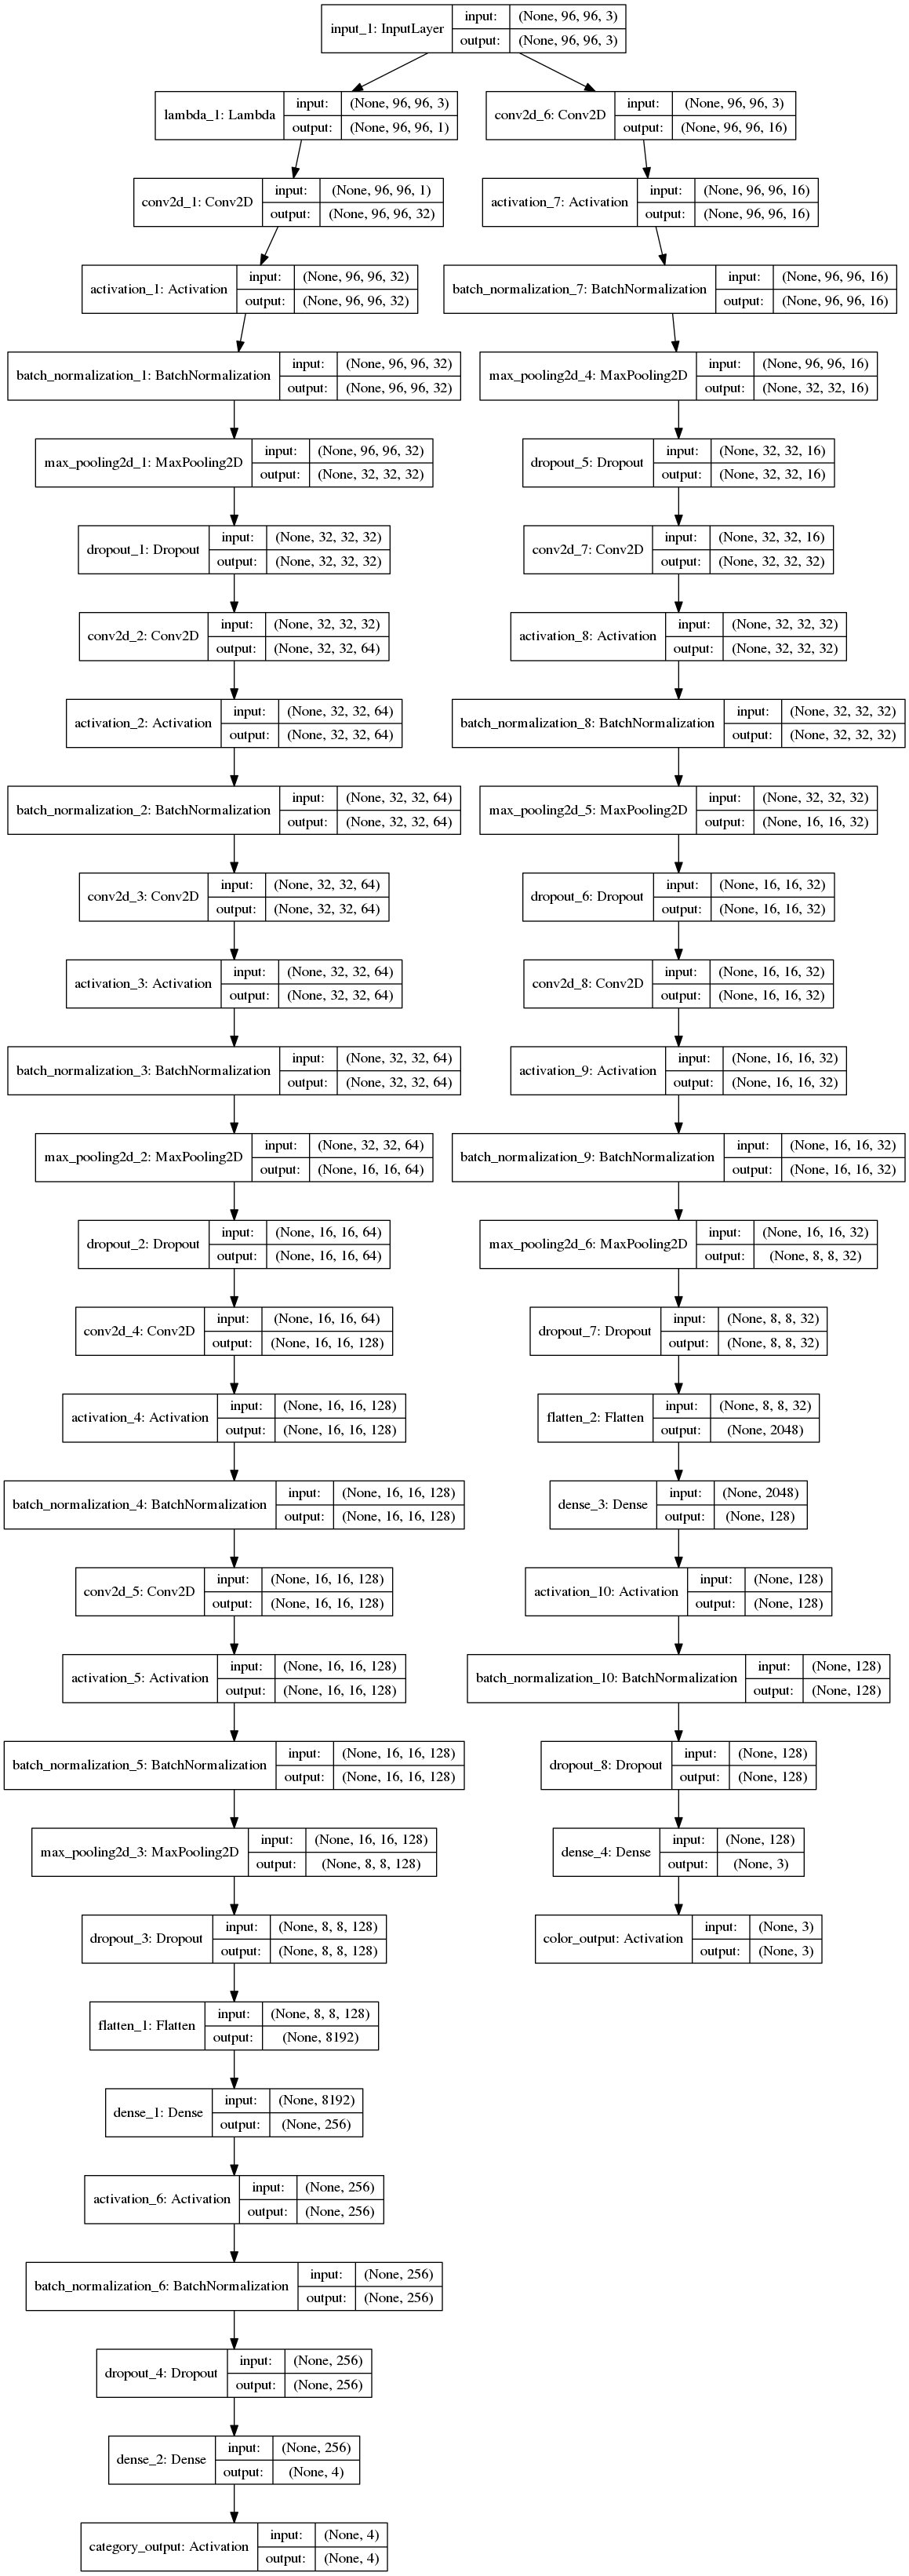

In [8]:
plot_model(model, to_file='model1.png', show_shapes='True')

## 5 define loss, weight and compile the model

In [9]:
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"category_output": "categorical_crossentropy",
	"color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

[INFO] compiling model...


## 6 model training

In [10]:
# train the network to perform multi-output classification
H = model.fit(trainX,
    {"category_output": trainCategoryY, "color_output": trainColorY},
    validation_data=(testX,
        {"category_output": testCategoryY, "color_output": testColorY}),
    epochs=EPOCHS,
    verbose=1)


Train on 2016 samples, validate on 505 samples
Epoch 1/50
2016/2016 [==============================] - 7s 3ms/step - loss: 0.8393 - category_output_loss: 0.5463 - color_output_loss: 0.2930 - category_output_accuracy: 0.8299 - color_output_accuracy: 0.8963 - val_loss: 3.8475 - val_category_output_loss: 2.5613 - val_color_output_loss: 1.2848 - val_category_output_accuracy: 0.3188 - val_color_output_accuracy: 0.4475
Epoch 2/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.3773 - category_output_loss: 0.2861 - color_output_loss: 0.0911 - category_output_accuracy: 0.9048 - color_output_accuracy: 0.9712 - val_loss: 5.0080 - val_category_output_loss: 2.5943 - val_color_output_loss: 2.4057 - val_category_output_accuracy: 0.3188 - val_color_output_accuracy: 0.4416
Epoch 3/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.2905 - category_output_loss: 0.2250 - color_output_loss: 0.0655 - category_output_accuracy: 0.9266 - color_output_accuracy: 0.9737 - v

## 7 plot the figures of loss and accuracy

In [11]:
# list all data in history
print(H.history.keys())

dict_keys(['val_loss', 'val_category_output_loss', 'val_color_output_loss', 'val_category_output_accuracy', 'val_color_output_accuracy', 'loss', 'category_output_loss', 'color_output_loss', 'category_output_accuracy', 'color_output_accuracy'])


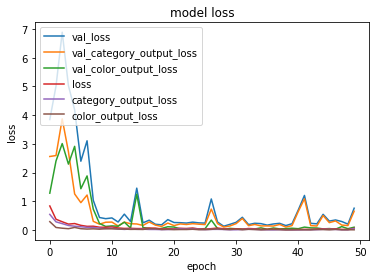

In [12]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.figure()
plt.plot(H.history['val_loss'])
plt.plot(H.history['val_category_output_loss'])
plt.plot(H.history['val_color_output_loss'])
plt.plot(H.history['loss'])
plt.plot(H.history['category_output_loss'])
plt.plot(H.history['color_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_category_output_loss','val_color_output_loss','loss','category_output_loss','color_output_loss'], loc='upper left')
plt.show()

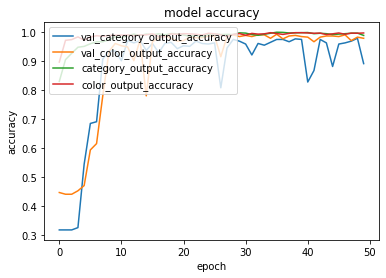

In [13]:
# summarize history for accuracy value
plt.figure()
plt.plot(H.history['val_category_output_accuracy'])
plt.plot(H.history['val_color_output_accuracy'])
plt.plot(H.history['category_output_accuracy'])
plt.plot(H.history['color_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_category_output_accuracy', 'val_color_output_accuracy','category_output_accuracy','color_output_accuracy'], loc='upper left')
plt.show()

## 8  testing

### 8.1 load test data

In [14]:
with open('test_data.pkl', 'rb') as file:
    testing_data = pickle.load(file)
    
image           = testing_data['res_data']       # resize test data
output          = testing_data['ori_data']       # original test data

print(image.shape)
print(output.shape)

(1, 96, 96, 3)
(666, 400, 3)


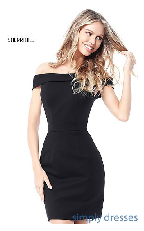

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open('examples/black_dress.jpg','r')
plt.imshow(im)
plt.axis('off')
plt.show()

### 8.2 predict the image

In [16]:
# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
(categoryProba, colorProba) = model.predict(image)

# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

[INFO] classifying image...


### 8.3 plot the results

In [17]:
# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
	categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
	colorProba[0][colorIdx] * 100)
cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

# display the predictions to the terminal as well
print("[INFO] {}".format(categoryText))
print("[INFO] {}".format(colorText))

[INFO] category: dress (83.45%)
[INFO] color: blue (84.63%)


In [18]:
# show the output image
# cv2.imshow("Output", output)
# cv2.waitKey(0)
# cv2.destroyAllWindows() # please press any Keyboard button otherwise it will stop the kernel

# PART2 1 input and 2 outputs with shared-layer for multi-task learning

## 1 load data

In [19]:
with open('data.pkl', 'rb') as file:
    all_data = pickle.load(file)

    
data           = all_data['data']           # original image data
categoryLB     = all_data['categoryLB']     # category name
colorLB        = all_data['colorLB']        # color name
categoryLabels = all_data['categoryLabels'] # category numeric labels
colorLabels    = all_data['colorLabels']    # color numeric labels

print(data.shape)
print(categoryLB)
print(colorLB)
print(categoryLabels.shape)
print(colorLabels.shape)

(2521, 96, 96, 3)
LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
(2521, 4)
(2521, 3)


## 2 data processing

In [20]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,
    test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,
    trainColorY, testColorY) = split

## 3 model construction

In [21]:
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation,Dropout,Lambda,Dense
from keras.layers import Flatten,Input,concatenate
import tensorflow as tf

class FashionNet_shared_layer:
    @staticmethod
    def build_category_color_branch(inputs, numCategories, numColors, finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        y = Conv2D(16, (3, 3), padding="same")(inputs)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(3, 3))(y)
        y = Dropout(0.25)(y)

        # CONV => RELU => POOL
        y = Conv2D(32, (3, 3), padding="same")(y)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(2, 2))(y)
        y = Dropout(0.25)(y)

        # CONV => RELU => POOL
        y = Conv2D(32, (3, 3), padding="same")(y)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(2, 2))(y)
        y = Dropout(0.25)(y)

        z = concatenate([x, y])
        z = Flatten()(z)
        z = Dense(256)(z)
        z = Activation("relu")(z)
        z = BatchNormalization()(z)
        z = Dropout(0.5)(z)

        xz = Dense(numCategories)(z)
        xz = Activation(finalAct, name="category_output")(xz)
        # return the category prediction sub-network

        yz = Dense(numColors)(z)
        yz = Activation(finalAct, name="color_output")(yz)
        # return the color prediction sub-network
        return xz, yz

    @staticmethod
    def build(width, height, numCategories, numColors,
        finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        categoryBranch, colorBranch = FashionNet_shared_layer.build_category_color_branch(inputs,
            numCategories, numColors, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[categoryBranch, colorBranch],
            name="fashionnet_shared_layer")

        # return the constructed network architecture
        return model

### The only difference between this example and the former example is the definition of the <font color = red> Build </font> function.

In [22]:
# initialize our FashionNet multi-output network
model1 = FashionNet_shared_layer.build(96, 96,
    numCategories=len(categoryLB.classes_),
    numColors=len(colorLB.classes_),
    finalAct="softmax")

model1.summary()

Model: "fashionnet_shared_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 96, 96, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 96, 96, 32)   320         lambda_2[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 96, 96, 32)   0           conv2d_9[0][0]                   
____________________________________________________________________________

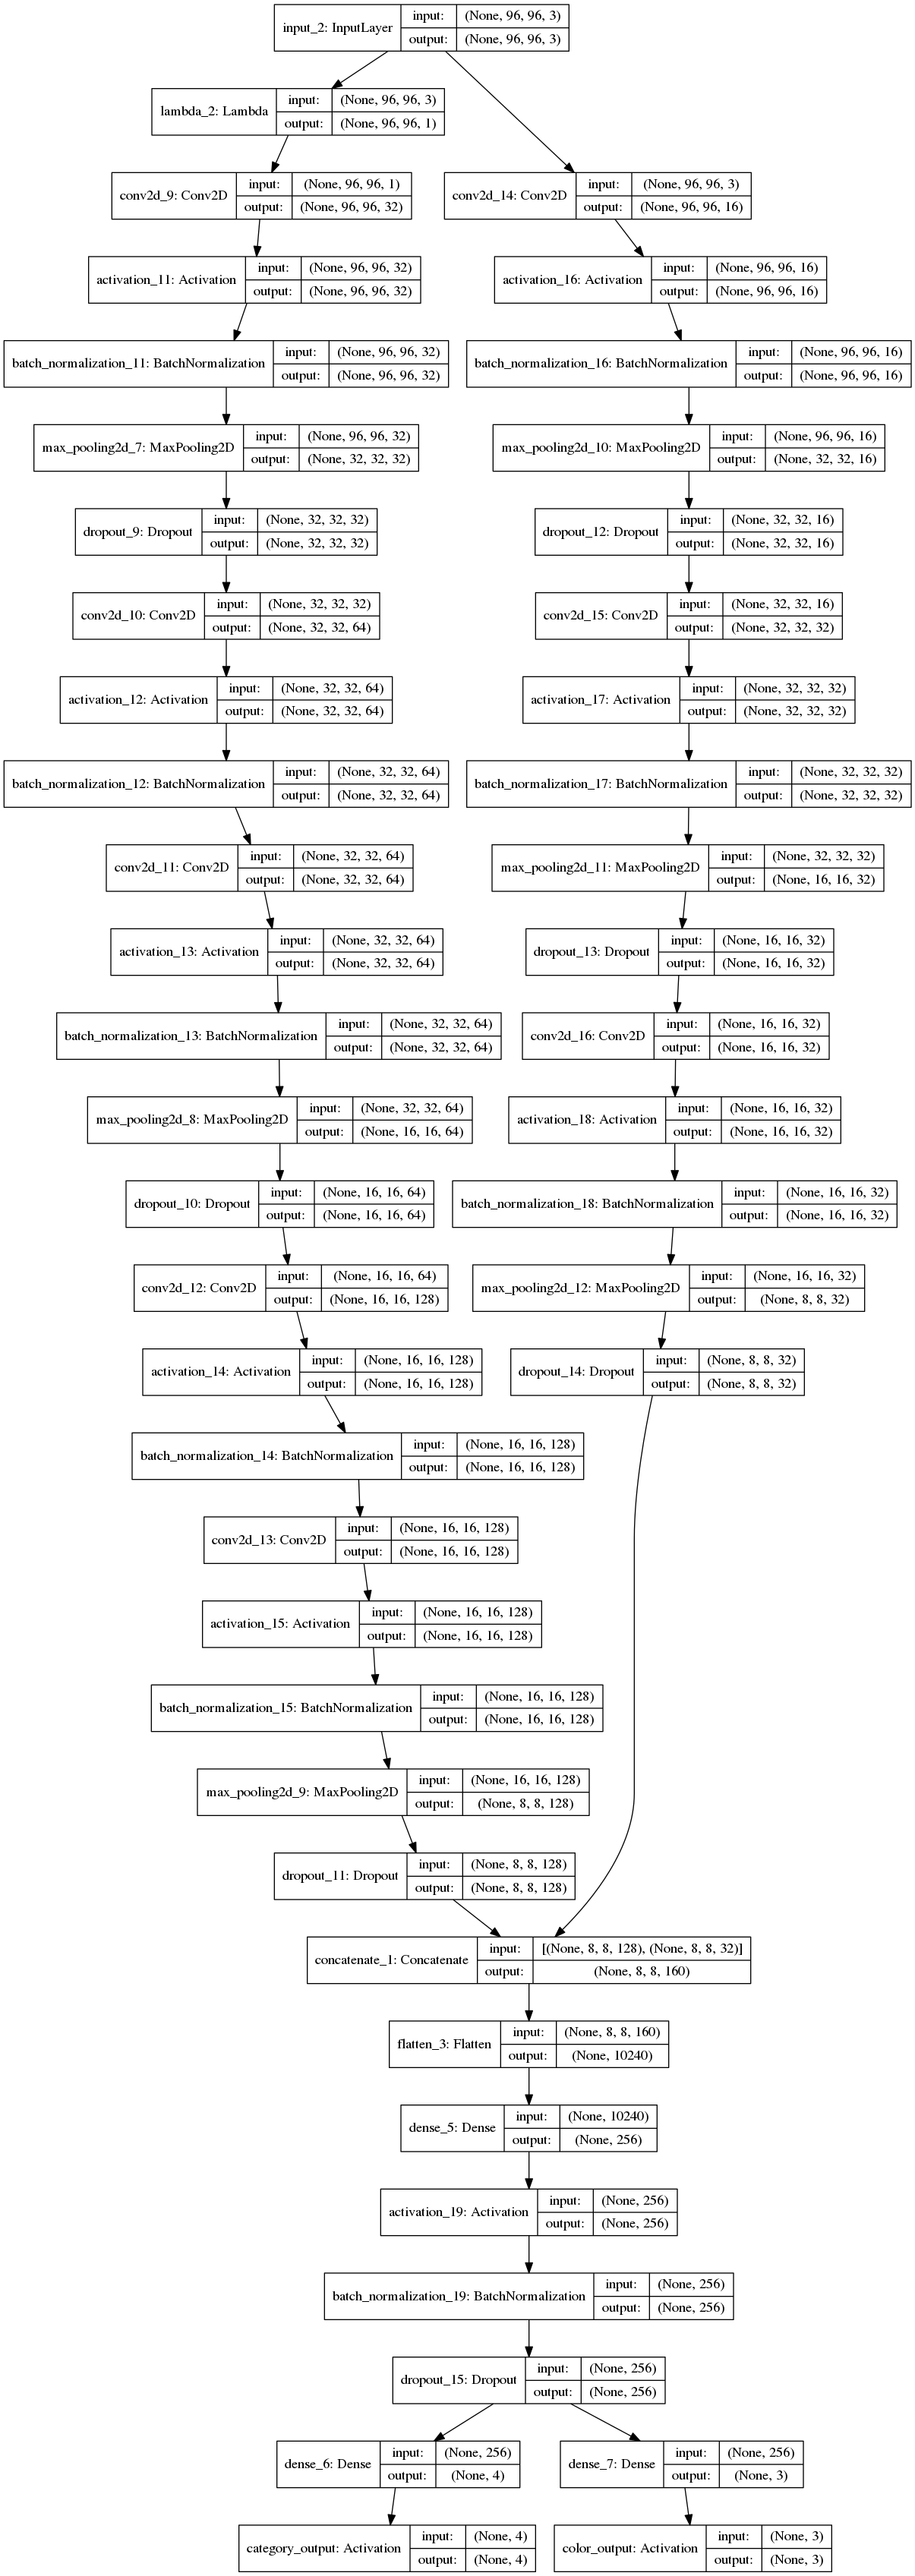

In [23]:
plot_model(model1, to_file='model2.png', show_shapes='True')

## 4 define loss, weight and compile the model

In [24]:
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"category_output": "categorical_crossentropy",
	"color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

[INFO] compiling model...


## 5 model training

In [25]:
# train the network to perform multi-output classification
H1 = model1.fit(trainX,
    {"category_output": trainCategoryY, "color_output": trainColorY},
    validation_data=(testX,
        {"category_output": testCategoryY, "color_output": testColorY}),
    epochs=EPOCHS,
    verbose=1)

Train on 2016 samples, validate on 505 samples
Epoch 1/50
2016/2016 [==============================] - 5s 2ms/step - loss: 0.8923 - category_output_loss: 0.4939 - color_output_loss: 0.3984 - category_output_accuracy: 0.8343 - color_output_accuracy: 0.8626 - val_loss: 4.2628 - val_category_output_loss: 2.0273 - val_color_output_loss: 2.2316 - val_category_output_accuracy: 0.3188 - val_color_output_accuracy: 0.4416
Epoch 2/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.3634 - category_output_loss: 0.2262 - color_output_loss: 0.1373 - category_output_accuracy: 0.9201 - color_output_accuracy: 0.9469 - val_loss: 4.7404 - val_category_output_loss: 1.8357 - val_color_output_loss: 2.8992 - val_category_output_accuracy: 0.3327 - val_color_output_accuracy: 0.4416
Epoch 3/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.2414 - category_output_loss: 0.1494 - color_output_loss: 0.0920 - category_output_accuracy: 0.9464 - color_output_accuracy: 0.9697 - va

## 6 plot the figures of loss and accuracy

In [26]:
# list all data in history
print(H1.history.keys())

dict_keys(['val_loss', 'val_category_output_loss', 'val_color_output_loss', 'val_category_output_accuracy', 'val_color_output_accuracy', 'loss', 'category_output_loss', 'color_output_loss', 'category_output_accuracy', 'color_output_accuracy'])


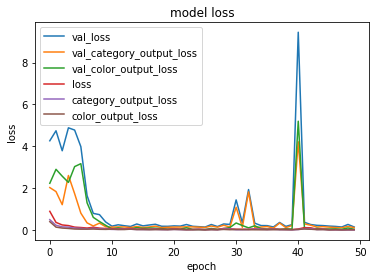

In [27]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.figure()
plt.plot(H1.history['val_loss'])
plt.plot(H1.history['val_category_output_loss'])
plt.plot(H1.history['val_color_output_loss'])
plt.plot(H1.history['loss'])
plt.plot(H1.history['category_output_loss'])
plt.plot(H1.history['color_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_category_output_loss','val_color_output_loss','loss','category_output_loss','color_output_loss'], loc='upper left')
plt.show()

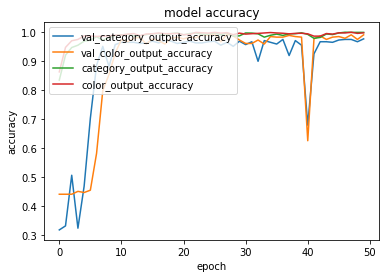

In [28]:
# summarize history for accuracy value
plt.figure()
plt.plot(H1.history['val_category_output_accuracy'])
plt.plot(H1.history['val_color_output_accuracy'])
plt.plot(H1.history['category_output_accuracy'])
plt.plot(H1.history['color_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_category_output_accuracy', 'val_color_output_accuracy','category_output_accuracy','color_output_accuracy'], loc='upper left')
plt.show()

## 7 testing

### 7.1 load test data

In [29]:
with open('test_data.pkl', 'rb') as file:
    testing_data = pickle.load(file)
    
image           = testing_data['res_data']       # resize test data
output          = testing_data['ori_data']       # original test data

print(image.shape)
print(output.shape)

(1, 96, 96, 3)
(666, 400, 3)


### 7.2 predict the image

In [30]:
# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
(categoryProba, colorProba) = model1.predict(image)

# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

[INFO] classifying image...


### 7.3 plot the results

In [31]:
# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
	categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
	colorProba[0][colorIdx] * 100)
cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

# display the predictions to the terminal as well
print("[INFO] {}".format(categoryText))
print("[INFO] {}".format(colorText))

[INFO] category: shoes (67.92%)
[INFO] color: black (97.37%)


# PART3 1 input and 1 output for multi-task learning

## 1 load data

In [32]:
with open('data.pkl', 'rb') as file:
    all_data = pickle.load(file)

    
data           = all_data['data']           # original image data
categoryLB     = all_data['categoryLB']     # category name
colorLB        = all_data['colorLB']        # color name
categoryLabels = all_data['categoryLabels'] # category numeric labels
colorLabels    = all_data['colorLabels']    # color numeric labels

print(data.shape)
print(categoryLB)
print(colorLB)
print(categoryLabels.shape)
print(colorLabels.shape)

(2521, 96, 96, 3)
LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
(2521, 4)
(2521, 3)


## 2 data processing

In [33]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,
    test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,
    trainColorY, testColorY) = split

## 3 model construction

In [34]:
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation,Dropout,Lambda,Dense
from keras.layers import Flatten,Input,concatenate
import tensorflow as tf

class FashionNet_one_output_layer:
    @staticmethod
    def build_category_color_branch(inputs, numCategories, numColors, finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        y = Conv2D(16, (3, 3), padding="same")(inputs)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(3, 3))(y)
        y = Dropout(0.25)(y)

        # CONV => RELU => POOL
        y = Conv2D(32, (3, 3), padding="same")(y)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(2, 2))(y)
        y = Dropout(0.25)(y)

        # CONV => RELU => POOL
        y = Conv2D(32, (3, 3), padding="same")(y)
        y = Activation("relu")(y)
        y = BatchNormalization(axis=chanDim)(y)
        y = MaxPooling2D(pool_size=(2, 2))(y)
        y = Dropout(0.25)(y)

        z = concatenate([x, y])
        z = Flatten()(z)
        z = Dense(256)(z)
        z = Activation("relu")(z)
        z = BatchNormalization()(z)
        z = Dropout(0.5)(z)

#         xz = Dense(numCategories)(z)
#         xz = Activation(finalAct, name="category_output")(xz)
        # return the category prediction sub-network

        yz = Dense(numColors)(z)
        yz = Activation(finalAct, name="color_output")(yz)
        # return the color prediction sub-network
        return yz

    @staticmethod
    def build(width, height, numCategories, numColors,
        finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        categoryBranch, colorBranch = FashionNet_shared_layer.build_category_color_branch(inputs,
            numCategories, numColors, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=colorBranch,
            name="fashionnet_shared_layer")

        # return the constructed network architecture
        return model

In [35]:
# initialize our FashionNet multi-output network
model2 = FashionNet_one_output_layer.build(96, 96,
    numCategories=len(categoryLB.classes_),
    numColors=len(colorLB.classes_),
    finalAct="softmax")

model2.summary()

Model: "fashionnet_shared_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 96, 96, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 96, 96, 32)   320         lambda_3[0][0]                   
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 96, 96, 32)   0           conv2d_17[0][0]                  
____________________________________________________________________________

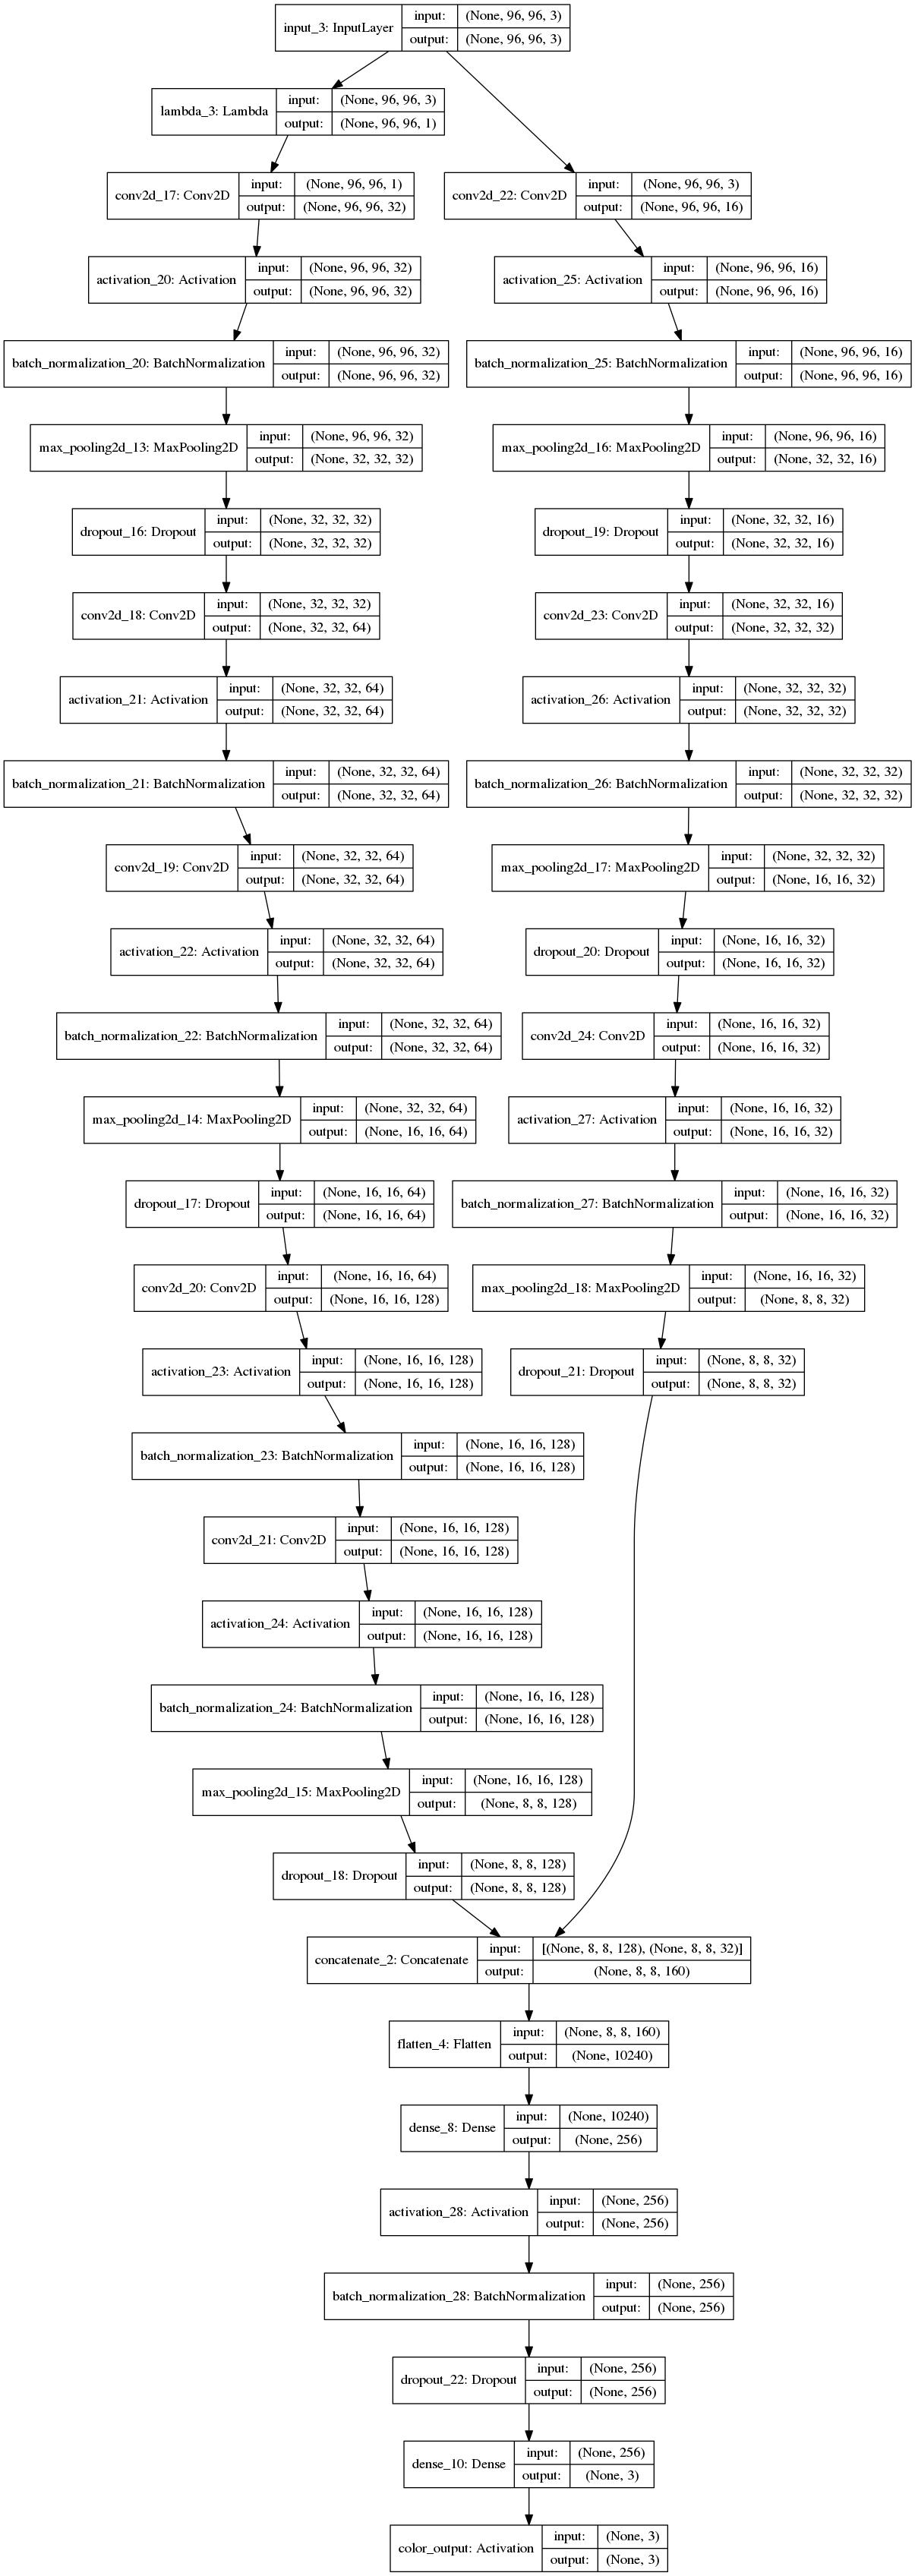

In [36]:
plot_model(model2, to_file='model2.png', show_shapes='True')

## 4 define loss, weight and compile the model

In [37]:
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"color_output": "categorical_crossentropy"
}
lossWeights = {"color_output": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

[INFO] compiling model...


## 5 model training

In [38]:
# train the network to perform multi-output classification
H2 = model2.fit(trainX,
    {"category_output": trainCategoryY, "color_output": trainColorY},
    validation_data=(testX,
        {"category_output": testCategoryY, "color_output": testColorY}),
    epochs=EPOCHS,
    verbose=1)

Train on 2016 samples, validate on 505 samples
Epoch 1/50
2016/2016 [==============================] - 5s 2ms/step - loss: 0.2918 - accuracy: 0.9013 - val_loss: 1.7557 - val_accuracy: 0.4693
Epoch 2/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.1204 - accuracy: 0.9559 - val_loss: 2.1821 - val_accuracy: 0.4455
Epoch 3/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.0892 - accuracy: 0.9688 - val_loss: 3.0723 - val_accuracy: 0.4475
Epoch 4/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.0666 - accuracy: 0.9792 - val_loss: 2.7632 - val_accuracy: 0.4554
Epoch 5/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.0494 - accuracy: 0.9851 - val_loss: 2.6378 - val_accuracy: 0.4871
Epoch 6/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.0349 - accuracy: 0.9886 - val_loss: 1.1938 - val_accuracy: 0.6772
Epoch 7/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.0546 - accu

## 6 plot the figures of loss and accuracy

In [39]:
# list all data in history
print(H2.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


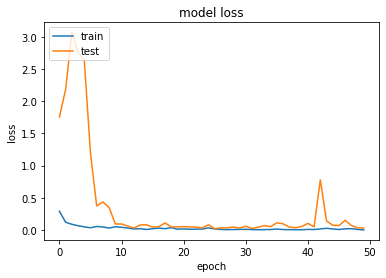

In [40]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure()
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

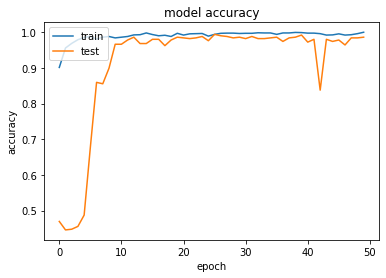

In [41]:
# summarize history for loss value
plt.figure()
plt.plot(H2.history['accuracy'])
plt.plot(H2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7 testing

### 7.1 load test data

In [42]:
with open('test_data.pkl', 'rb') as file:
    testing_data = pickle.load(file)
    
image           = testing_data['res_data']       # resize test data
output          = testing_data['ori_data']       # original test data

print(image.shape)
print(output.shape)

(1, 96, 96, 3)
(666, 400, 3)


### 7.2 predict the image

In [43]:
# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
colorProba = model2.predict(image)

# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
colorIdx = colorProba[0].argmax()
colorLabel = colorLB.classes_[colorIdx]

[INFO] classifying image...


### 7.3 plot the results

In [44]:
# draw the color label on the image
colorText = "color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# display the predictions to the terminal as well
print("[INFO] {}".format(colorText))

[INFO] color: black (71.58%)
